# Исследование объявлений о продаже квартир

Данные - архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 

Задача - исследовать факторы, влияющие на рыночную стоимость объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re
import math

In [2]:
# формирование датафрейма
data = pd.read_csv('real_estate_data.csv', sep='\t')
data.head() 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
# общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В датафрейме 22 колонки, 23699 строк, много пропущенных значений в столбцах.

In [4]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


В некоторых столбцах уже прослеживаются аномальные значения.

Предварительные выводы о данных.
Средняя квартира в объявлении выглядит так:
- 9 фотографий жилого помещения;
- цена - 4.65 млн рублей;
- площадь квартиры - 52 кв. м;
- количество комнат - 2;
- высота потолков - 2.65 м;
- количество этажей в здании - 9;
- площадь жилой зоны - 30 кв. м;
- квартира находится на 4 этаже;
- площадь кухни - 9 кв. м;
- один балкон;
- расстояние от квартиры до аэропорта - 27 км;
- центр города расположен в 13 км от квартиры;
- рядом парков нет (в пределах 3 км);
- если парки есть, то обычно в радиусе 500 м;
- рядом есть один водоем;
- если водоемы есть, то обычно в радиусе 500 м;
- обычно объявление висит 95 дней.

## Предобработка данных

### Переименование столбцов

Переименуем столбцы для дальнейшего удобства работы с ними.
- `cityCenters_nearest` -> `city_centers_nearest` ("верблюжий" регистр)
- `open_plan` -> `is_open_plan` (добавим "is_", чтобы название столбца явно отображало, что имеем дело с булевыми значениями)
- `studio` -> `is_studio`

In [5]:
# переименование:
data = data.rename(columns={
    'cityCenters_nearest': 'city_centers_nearest',
    'open_plan': 'is_open_plan',
    'studio': 'is_studio'
})
# проверка
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'is_studio', 'is_open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Теперь названия столбцов выглядят приемлемо. 

### Устранение дубликатов

Найдем явные дубликаты.

In [6]:
print('Кол-во дубликатов:', data.duplicated().sum())

Кол-во дубликатов: 0


Явных дубликтов в датафрейме нет. Займемся поиском неявных дубликатов.  
В колонке с названиями населенных пунктов `locality_name` возможны неявные дубликаты.

In [7]:
data.locality_name.unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [8]:
print('Кол-во уникальных названий:', data.locality_name.nunique())

Кол-во уникальных названий: 364


Обнаруженные проблемы:
- написание "поселок" через е/ё;
- у одного населенного пункта несколько типов: "поселок городского типа"/ "городской поселок", что одно и то же.

In [9]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
print('Кол-во уникальных названий:', data.locality_name.nunique())

Кол-во уникальных названий: 330


In [10]:
# уникальные названия нас. пунктов
unique_loc_names = data['locality_name'].dropna().unique()

# получение имен собственных из названий населенных пунктов
only_names = []
for words in unique_loc_names:
    words_list = words.split()
    buff = []
    for word in words_list:
        if word.istitle():
            buff.append(word)
    if len(buff) > 1:
        buff = [" ".join(buff)]
    only_names.append(buff)  
    
# избавление от списков
only_names = pd.Series(only_names).apply(lambda x: ''.join(x))

# уникальные имена собственные
loc_names = only_names.unique()

In [11]:
def change_loc_name(name):
    """ функция заменяет названия нас. пунктов на имена собственные """
    for loc in loc_names:
        try:
            if loc in name:
                return loc
        except:
            return np.nan

In [12]:
data['locality_name'] = data['locality_name'].apply(change_loc_name)
print('Кол-во уникальных названий:', data['locality_name'].nunique())

Кол-во уникальных названий: 293


Неявные дубликаты из колонки были устранены.

### Поиск и устранение аномальных значений

Для поиска выбросов воспользуемся квантилями.

In [13]:
def outliers(column, q1=0.25, q3=0.75):
    """функция возвращает индексы записей с выбросами"""
    q1 = data[column].quantile(q1)
    q3 = data[column].quantile(q3)
    iqr = q3 - q1 
    low = q1 - (1.5*iqr)
    high = q3 + (1.5*iqr)
    outs_idx = data[column][((data[column] < low) | (data[column] > high)) & (~data[column].isna())].index
    return outs_idx

In [14]:
print('Количество записей в даатфрейме на начало этапа:', data.shape[0])

Количество записей в даатфрейме на начало этапа: 23699


#### total_images

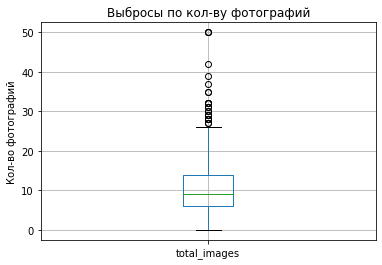

In [15]:
data['total_images'].plot(kind='box',
                          title='Выбросы по кол-ву фотографий',
                          ylabel='Кол-во фотографий',
                          grid=True
                         );

In [16]:
print('Кол-во выбросов:', len(outliers('total_images')))

Кол-во выбросов: 25


In [17]:
data = data.drop(outliers('total_images'))
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 23674


Выбросы удалены.

#### last_price

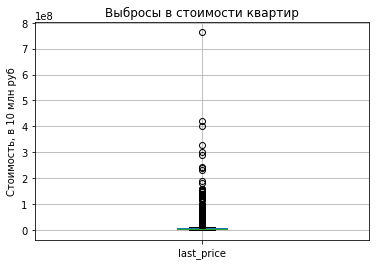

In [18]:
data['last_price'].plot(kind='box',
                          title='Выбросы в стоимости квартир',
                          ylabel='Стоимость, в 10 млн руб',
                          grid=True
                         );

In [19]:
print('Количество выбросов:', len(outliers('last_price')))

Количество выбросов: 2056


Записи с выбросами составляют почти 10% от общего объема датафрейма. Удалять их нельзя. Изменим значение квантилей: q1=0.1, q3=0.9 и найдем выбросы.

In [20]:
print('Количество выбросов:', len(outliers('last_price', q1=0.1, q3=0.9)))

Количество выбросов: 541


Удалим данные выбросы.

In [21]:
data = data.drop(outliers('last_price', q1=0.1, q3=0.9))
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 23133


Посмотрим минимальные и максимальные значения в столбце.

In [22]:
data['last_price'].describe()

count    2.313300e+04
mean     5.535536e+06
std      3.487332e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.590000e+06
75%      6.500000e+06
max      2.350000e+07
Name: last_price, dtype: float64

Квартира за 12 тыс. руб - слишком дешево, явно ошибка в цене. Избавимся от этой записи.

In [23]:
data = data.drop(data[data['last_price'] == data['last_price'].min()].index)

Теперь все выбросы удалены.

#### total_area

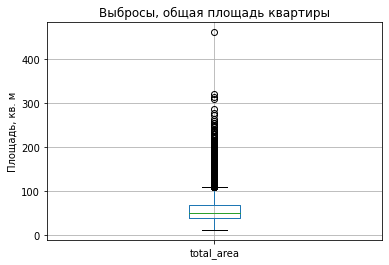

In [24]:
data['total_area'].plot(kind='box',
                          title='Выбросы, общая площадь квартиры',
                          ylabel='Площадь, кв. м',
                          grid=True
                         );

In [25]:
print('Количество выбросов:', len(outliers('total_area', q1=0.1, q3=0.9)))

Количество выбросов: 124


In [26]:
data = data.drop(outliers('total_area', q1=0.1, q3=0.9))
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 23008


In [27]:
data.total_area.describe()

count    23008.000000
mean        56.474071
std         23.323730
min         12.000000
25%         40.000000
50%         51.000000
75%         67.200000
max        171.000000
Name: total_area, dtype: float64

#### living_area

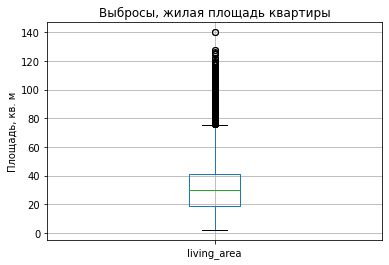

In [28]:
data['living_area'].plot(kind='box',
                          title='Выбросы, жилая площадь квартиры',
                          ylabel='Площадь, кв. м',
                          grid=True
                         );

In [29]:
print('Количество выбросов:', len(outliers('living_area', q1=0.1, q3=0.9)))

Количество выбросов: 55


In [30]:
data = data.drop(outliers('living_area', q1=0.1, q3=0.9))
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 22953


По нормативам жилая площадь не должна быть меньше 8 кв. м.

In [31]:
data = data.query('living_area >= 8 | living_area.isna()')
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 22946


Аномальные значения удалены.

#### kitchen_area

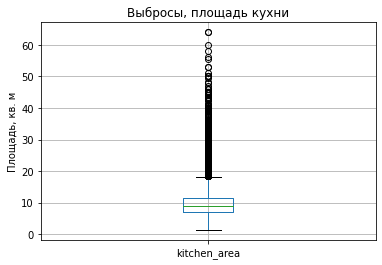

In [32]:
data['kitchen_area'].plot(kind='box',
                          title='Выбросы, площадь кухни',
                          ylabel='Площадь, кв. м',
                          grid=True
                         );

In [33]:
print('Количество выбросов:', len(outliers('kitchen_area', q1=0.1, q3=0.9)))

Количество выбросов: 230


Выбросов слишком много, чтобы так просто от них избавиться.  
Будем руководствоваться нормативами и удалим только те записи, где площадь кухни менее 5 кв. м.

In [34]:
data = data.query('kitchen_area >= 5 | kitchen_area.isna()')
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 22841


Аномальные значения удалены.

In [35]:
# сброс индексов для корректного удаления строк в дальнейшем
data.reset_index(drop=True, inplace=True)

#### total_area, living_area, kitchen_area

Общая площадь должна быть больше суммы жилой площади и кухни. Помимо этих площадей существует еще и площадь нежилых помещений, в которую, кстати, входит площадь кухни.  
То есть формула общей площади будет такой:  

$$ S_{общ} = S_{кухня} + S_{жилая} + S_{нежилая} $$ где
$S_{нежилая} $ - нежилая площадь без кухни.  

Здесь и далее обусловимся, что нежилая площадь - это площадь без кухни.

Посмотрим как выглядит нежилая площадь. И определим нижнюю границу этой площади, чтобы использовать в формуле.

count    20227.000000
mean        14.251218
std          7.543671
min        -29.800000
25%          9.400000
50%         12.500000
75%         17.100000
max        100.000000
Name: area, dtype: float64

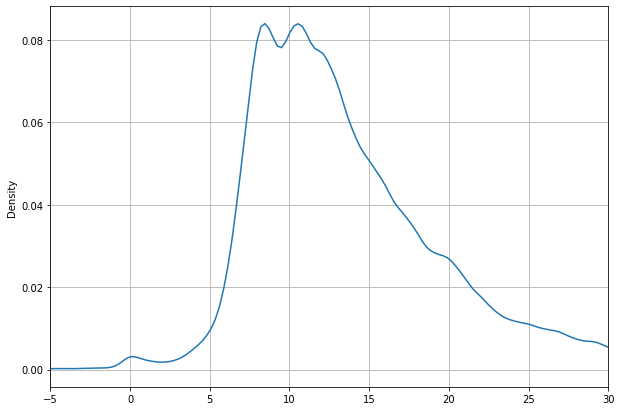

In [36]:
# создадим временный столбец area. в нем запишем нежилую площадь
data['area'] = data['total_area'] - (data['living_area'] + data['kitchen_area'])
data.area.plot.density(bw_method=0.07, figsize=(10, 7), grid=True)
plt.xlim(-5, 30)
data.area.describe()

Обусловимся, что минимальная нежилая площадь будет составлять 5 кв. м.

In [37]:
# nla - non living area
nla = 5

In [38]:
print('Кол-во аномалий:', 
      data.query('(living_area + kitchen_area + @nla) > total_area').shape[0])

Кол-во аномалий: 402


Удалить такое кол-во записей мы не можем, нужно исправить данные.  

Если правая часть формулы будет больше общей площади, то увеличиваем общую площадь, чтобы она была равна правой части.

In [39]:
data.loc[data['total_area'] < (data['living_area'] + data['kitchen_area'] + nla), 'total_area'] =\
    data['living_area'] + data['kitchen_area'] + nla

print('Кол-во аномалий после исправления:', data.query('(living_area + kitchen_area + @nla) > total_area').shape[0])

Кол-во аномалий после исправления: 0


In [40]:
# удаление вспомогательного столбца
data = data.drop('area', axis=1)

Аномальные значения найдены и исправлены.

#### first_day_exposition  

In [41]:
data['first_day_exposition'].describe()

count                   22841
unique                   1487
top       2018-02-01T00:00:00
freq                      354
Name: first_day_exposition, dtype: object

Столбец без аномалий.

#### rooms

In [42]:
# сброс индексов для корректного удаления строк в дальнейшем
data.reset_index(drop=True, inplace=True)

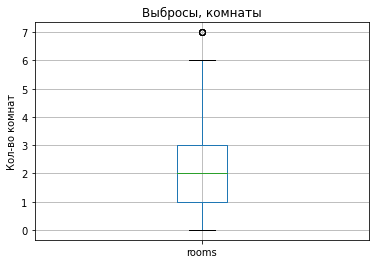

In [43]:
data['rooms'].plot(kind='box',
                          title='Выбросы, комнаты',
                          ylabel='Кол-во комнат',
                          grid=True
                         );

In [44]:
print('Кол-во выбросов:', len(outliers('rooms')))

Кол-во выбросов: 5


In [45]:
data = data.drop(outliers('rooms'))
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 22836


Выбросы удалены.

#### ceiling_height

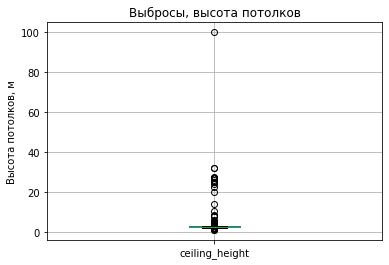

In [46]:
data['ceiling_height'].plot(kind='box',
                          title='Выбросы, высота потолков',
                          ylabel='Высота потолков, м',
                          grid=True
                         );

Согласно нормам застройки, минимальная высота потолков 2,4 м. В некоторых квартирах люкс-класса потолки могут достигать 4 м.
Также видим двузначные высоты потолков, это ,вероятно, ошибка пользователей: неправильно поставили запятую. Имели в виду 2,75, а ввели 27,5.   
Будем удалять строки с высотой потолков ниже 2,4 м и больше 4 м. Cтроки с высотой от 24 м исправляем.

In [47]:
# домножим ошибочные значения на 0.1
data.loc[data['ceiling_height'] > 24, 'ceiling_height'] = data.loc[data['ceiling_height'] > 24, 'ceiling_height'] * 0.1

# Удалим из датафрейма строки с потолками ниже 2.4 м и выше 4 м
data = data.query('2.4 <= ceiling_height <= 4 | ceiling_height.isna()')

print('Кол-во записей в датафрейме после удаления аномалий:', data.shape[0])

Кол-во записей в датафрейме после удаления аномалий: 22778


Удалим выбросы.

In [48]:
data = data.drop(outliers('ceiling_height', q1=0.1, q3=0.9))
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 22712


Аномальные значения и выбросы удалены, где было можно - исправлены.

#### floors_total

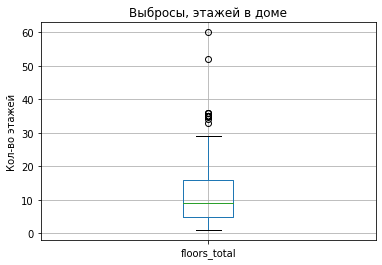

In [49]:
data['floors_total'].plot(kind='box',
                          title='Выбросы, этажей в доме',
                          ylabel='Кол-во этажей',
                          grid=True
                         );

In [50]:
print('Кол-во выбросов:', len(outliers('floors_total')))

Кол-во выбросов: 31


In [51]:
data = data.drop(outliers('floors_total'))
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 22681


Похоже, что в датасет попали объявления с частными домами. Такого быть не должно, в базе представлены только квартиры, так что удалим строки, в которых количество этажей равняется 1.

In [52]:
print('Кол-во аномалий:', data.query('floors_total == 1').shape[0])
data = data.query('floors_total != 1')
print('Кол-во записей в датафрейме после удаления аномалий:', data.shape[0])

Кол-во аномалий: 23
Кол-во записей в датафрейме после удаления аномалий: 22658


#### floor

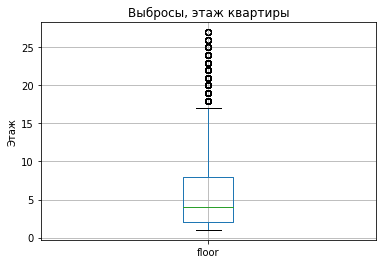

In [53]:
data['floor'].plot(kind='box',
                          title='Выбросы, этаж квартиры',
                          ylabel='Этаж',
                          grid=True
                         );

In [54]:
print('Кол-во выбросов:', len(outliers('floor', q1=0.1, q3=0.85)))

Кол-во выбросов: 8


In [55]:
data = data.drop(outliers('floor', q1=0.1, q3=0.85))
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 22650


Проверим, есть ли квартиры, которые бы располагались выше последнего этажа в доме.

In [56]:
print('Кол-во аномалий:', data.query('floor > floors_total').shape[0])

Кол-во аномалий: 0


Без аномалий. Выбросы удалены.

#### is_apartment

In [57]:
data.is_apartment.value_counts()

False    2611
True       38
Name: is_apartment, dtype: int64

Каких-либо аномалий или выбросов здесь нет.

#### is_studio

Квартиры-студии - это квартиры с одной комнатой или с 0 комнат? Для определения аномалий нужно разобраться с этим моментом. 

Посмотрим, сколько комнат у студий.

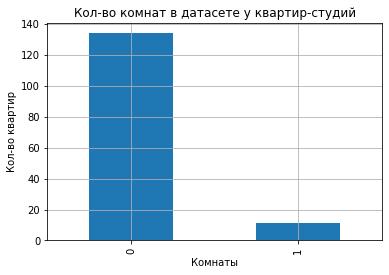

In [58]:
data.query('is_studio == True')['rooms'].value_counts().plot(kind='bar',
                                                             title='Кол-во комнат в датасете у квартир-студий',
                                                             xlabel='Комнаты',
                                                             ylabel='Кол-во квартир',
                                                             grid=True
                                                            );

У большинства студий отсутствуют комнаты, их 0.  
Для студий считаем, что если кол-во комнат больше 0, то это аномалия.

In [59]:
print('Кол-во аномалий:', data.query('is_studio == True & rooms > 0').shape[0])

Кол-во аномалий: 11


In [60]:
data.loc[(data['is_studio'] == True) & (data['rooms'] > 0), 'rooms'] = 0

In [61]:
print('Кол-во аномалий:', data.query('is_studio == True & rooms > 0').shape[0])

Кол-во аномалий: 0


In [62]:
# сброс индексов для корректного удаления строк в дальнейшем
data.reset_index(drop=True, inplace=True)

Проверим записи с 0 комнат, у которых нет метки о том, что это студии.

In [63]:
print('Кол-во аномалий:', data.loc[(data['rooms'] == 0) & (data['is_studio'] == False)].shape[0])

Кол-во аномалий: 57


In [64]:
data.loc[(data['rooms'] == 0) & (data['is_studio'] == False), 'is_studio'] =\
    data.loc[(data['rooms'] == 0) & (data['is_studio'] == False), 'is_studio'].replace(False, True)

In [65]:
print('Кол-во аномалий:', data.loc[(data['rooms'] == 0) & (data['is_studio'] == False), 'is_studio'].shape[0])

Кол-во аномалий: 0


Аномалии исправлены.

#### is_open_plan

In [66]:
data.is_open_plan.value_counts()

False    22586
True        64
Name: is_open_plan, dtype: int64

Аномалий нет.

#### balcony

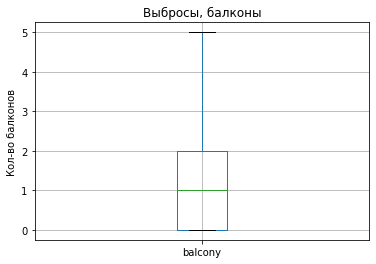

In [67]:
data['balcony'].plot(kind='box',
                          title='Выбросы, балконы',
                          ylabel='Кол-во балконов',
                          grid=True
                         );

In [68]:
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

Балконы могут быть на кухне и в каждой комнате. Например, для двухкомнатной квартиры максимальное кол-во балконов - 3.  
Проверим это. Если где-то балконов будет больше исправим это значение.

In [69]:
print('Кол-во аномалий:', data.query('(rooms + 1) < balcony').shape[0])

Кол-во аномалий: 430


In [70]:
def balcony_num(row):
    balcony = row['balcony']
    rooms = row['rooms']
    if balcony > (rooms + 1):
        new_balcony = rooms + 1
    else:
        new_balcony = balcony
    return new_balcony

In [71]:
data['balcony'] = data.apply(balcony_num, axis=1)

In [72]:
print('Кол-во аномалий:', data.query('(rooms + 1) < balcony').shape[0])
print('Кол-во записей в датафрейме после исправления аномалий:', data.shape[0])

Кол-во аномалий: 0
Кол-во записей в датафрейме после исправления аномалий: 22650


Аномалии удалены.

#### airports_nearest

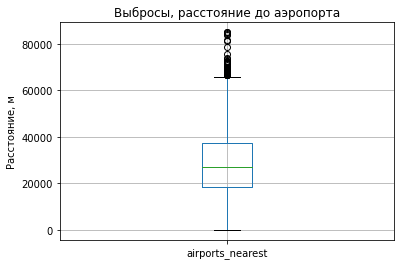

In [73]:
data['airports_nearest'].plot(kind='box',
                          title='Выбросы, расстояние до аэропорта',
                          ylabel='Расстояние, м',
                          grid=True
                         );

In [74]:
print('Кол-во выбросов:', len(outliers('airports_nearest')))

Кол-во выбросов: 88


In [75]:
data = data.drop(outliers('airports_nearest'))
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 22562


In [76]:
display(data['airports_nearest'].describe())
data = data.query('airports_nearest != 0')
print('Кол-во записей в датафрейме после удаления аномалии:', data.shape[0])

count    17133.000000
mean     28679.994572
std      12455.349979
min          0.000000
25%      18349.000000
50%      26911.000000
75%      37407.000000
max      65568.000000
Name: airports_nearest, dtype: float64

Кол-во записей в датафрейме после удаления аномалии: 22561


Выбросы и аномалии удалены

#### city_centers_nearest

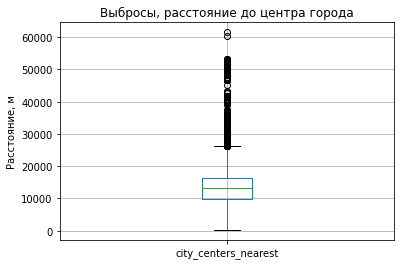

In [77]:
data['city_centers_nearest'].plot(kind='box',
                          title='Выбросы, расстояние до центра города',
                          ylabel='Расстояние, м',
                          grid=True
                         );

In [78]:
print('Кол-во выбросов:', len(outliers('city_centers_nearest', q1=0.1, q3=0.9)))
data = data.drop(outliers('city_centers_nearest', q1=0.1, q3=0.9))
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во выбросов: 2
Кол-во записей в датафрейме после удаления выбросов: 22559


Выбросы удалены.

#### parks_around3000, parks_nearest

In [79]:
# сброс индексов для корректного удаления строк
data.reset_index(drop=True, inplace=True)

Выбросы в столбце parks_around3000 искать нет смысла, там всего 4 значения, они категориальные.  
Выбросы в столбце parks_nearest тоже искать не будем, т.к. поломается корреляция с parks_around3000. Удалим только значения свыше 3000 м. 

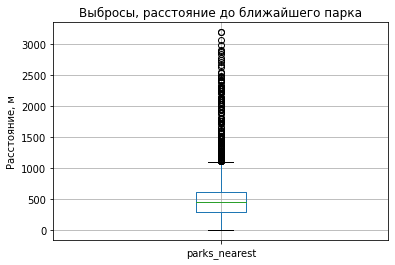

In [80]:
data['parks_nearest'].plot(kind='box',
                          title='Выбросы, расстояние до ближайшего парка',
                          ylabel='Расстояние, м',
                          grid=True
                         );

In [81]:
print('Кол-во выбросов:', data[data['parks_nearest'] > 3000].shape[0])
data = data.drop(data[(data['parks_nearest'] > 3000)].index)    
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во выбросов: 3
Кол-во записей в датафрейме после удаления выбросов: 22556


In [82]:
print('Кол-во аномалий:', 
      data.query('(parks_around3000 in [1, 2, 3] & parks_nearest == 0) | (parks_around3000 == 0 & parks_nearest < 3001)')
      .shape[0])

Кол-во аномалий: 0


Проверили столбцы попарно на аномалии:  
- в пределах 3 км есть парки, а ближайший не обозначен; 
- в пределах 3 км нет парков, а ближайший обозначен в пределах 3 км.

Аномалий нет. Выбросы удалены.

#### ponds_around3000, ponds_nearest

In [83]:
print('Кол-во выбросов:', len(outliers('ponds_nearest')))

Кол-во выбросов: 0


In [84]:
print('Кол-во аномалий:', 
      data.query('(ponds_around3000 in [1, 2, 3] & ponds_nearest == 0) | (ponds_around3000 == 0 & ponds_nearest < 3001)')
      .shape[0])

Кол-во аномалий: 0


Выполнили аналогичную проверку из прошлого пункта.  
Анмоалий и выбросов не обнаружено.

#### days_exposition

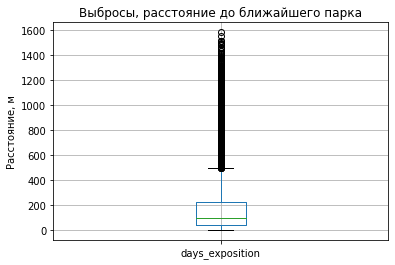

In [85]:
data['days_exposition'].plot(kind='box',
                          title='Выбросы, расстояние до ближайшего парка',
                          ylabel='Расстояние, м',
                          grid=True
                         );

Выбросов получается слишком много, удалять так много данных мы себе позволить не можем. Сделаем квантили поменьше.

In [86]:
print('Кол-во выбросов:', len(outliers('days_exposition', q1=0.05, q3=0.95)))
data = data.drop(outliers('days_exposition', q1=0.05, q3=0.95))

Кол-во выбросов: 1


In [87]:
print('Кол-во записей в датафрейме после удаления выбросов:', data.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 22555


Выбросы удалены.

#### Выводы

In [88]:
print('Количество записей в даатфрейме на начало этапа:', data.shape[0])

Количество записей в даатфрейме на начало этапа: 22555


Был произведен поиск и устранение аномалий и выбросов по всем столбцам таблицы. Для поиска аномальных значений были использованы: метод `describe()`, построение "ящика с усами". Все найденные аномалии были или исправлены, или удалены.  

При подготовке данных количество строк в датафрейме сократилось. 23699 -> 22436

### Удаление пропусков

In [89]:
# определение пропусков в столбцах
# переменную sum_na в дальнейшем используем для статистики изменений
sum_na = data.isna().sum()
sum_na

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           8844
floors_total               84
living_area              1796
floor                       0
is_apartment            19917
is_studio                   0
is_open_plan                0
kitchen_area             2172
balcony                 10894
locality_name              46
airports_nearest         5428
city_centers_nearest     5410
parks_around3000         5409
parks_nearest           15159
ponds_around3000         5409
ponds_nearest           14187
days_exposition          2927
dtype: int64

#### Пропуски в ceiling_height

Скорее всего пропуски здесь обусловлены тем, что пользователь не заполнил значение высоты потолков.  
Удалить строки с пропущенными значениями нельзя, пропадёт более четверти данных.  

Заполнять пропущенные значения будем медианой для домов разной этажности. Для записей, в которых не найдется заполненное значение этажа, заполним медианой по всему датафрейму.

In [90]:
print('Кол-во пропусков:', data.ceiling_height.isna().sum())

Кол-во пропусков: 8844


In [91]:
data['ceiling_height'].fillna(data.groupby('floors_total')['ceiling_height'].transform('median'), inplace=True)

data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)
# проверка на пропуски
print('Кол-во пропусков после устранения:', data.ceiling_height.isna().sum())

Кол-во пропусков после устранения: 0


От пропусков в столбце ceiling_height успешно избавились.

#### Пропуски в floors_total

Опять же, пропуски здесь могут быть обусловлены тем, что продавец ничего не написал в соответствующей графе о количестве этажей.  
Количество этажей в здании должно быть равным или превышать этаж квартиры в объявлении. Пропуски заполним медианой этажности домов от этажа квартиры.

In [92]:
print('Кол-во пропусков:', data.floors_total.isna().sum())

Кол-во пропусков: 84


In [93]:
data['floors_total'].fillna(data.groupby('floor')['floors_total'].transform('median'), inplace=True)

print('Кол-во пропусков после устранения:', data.floors_total.isna().sum())

Кол-во пропусков после устранения: 0


Пропуски для `floors_total` заполнены.

In [94]:
# сброс индексов для корректного удаления строк
data.reset_index(drop=True, inplace=True)

#### Пропуски в  living_area <a id='living_area_nan'></a>

`living_area` очень сильно коррелирует с `total_area`, сильно - с `rooms` и средне - с `kitchen_area`.    
К жилой площади не относятся кухня и другие помещения, непригодные для проживания. Поэтому можно прикинуть, что значения `living_area` < `total_area` - `kitchen_area`. Т.к. у `kitchen_area` тоже есть пропуски и они могут пересекаться с пропусками в `living_area`, то мы не можем использовать площадь кухни для расчёта площади жилого помещения. 

In [95]:
print('Кол-во пропусков:', data.living_area.isna().sum())

Кол-во пропусков: 1796


In [96]:
data.corr()['living_area'].sort_values(ascending=False).head()

living_area       1.000000
total_area        0.920379
rooms             0.882333
last_price        0.647981
ceiling_height    0.283824
Name: living_area, dtype: float64

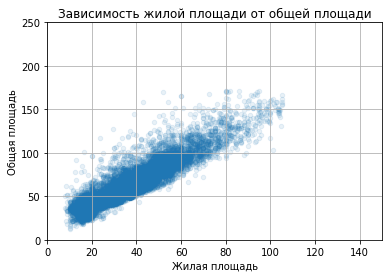

In [97]:
# диаграмма рассеяния, демонстрирующая корреляцию:
data.plot(
    x='living_area', 
    y='total_area', 
    kind='scatter', 
    alpha=0.1, 
    title='Зависимость жилой площади от общей площади', 
    xlabel='Жилая площадь', 
    ylabel='Общая площадь',
    grid=True,
    xlim=(0, 150),
    ylim=(0, 250)
);

Создадим сводную таблицу и функцию, чтобы заполнить пропущенные значения на основе количества комнат и значений доли жилой площади в общей площади.

In [98]:
# посчитаем, какую долю занимает жилая площадь от общей площади квартиры в зависимости от количества комнат:
living_area_ratio = data.pivot_table(index='rooms', values=['living_area', 'total_area'], aggfunc=['median'])
living_area_ratio.columns = ['living_area', 'total_area']
living_area_ratio['ratio'] = living_area_ratio['living_area'] / living_area_ratio['total_area']
# взглянем на получившуюся сводную таблицу
living_area_ratio
# функция принимает строку датафрейма, а именно значения столбцов total_area и rooms
def fill_living_area(row):
    total_area = row['total_area']
    rooms = row['rooms']
    kitchen_area = row['kitchen_area']
    
    # новое значение жилой площади будет произведением ratio и общей площади
    new_living_area = living_area_ratio.loc[rooms, 'ratio'] * total_area
    
    # не допускаем, чтобы жилая площадь стала меньше нормативного минимума в 9 кв м:
    if new_living_area + kitchen_area + nla > total_area:
        new_living_area = total_area - (kitchen_area + nla)
    if new_living_area < 8:
        new_living_area = 8
    return round(new_living_area, 2)

# применяем функцию для пропущенных значений столбца Living_area
data.loc[data['living_area'].isna(), 'living_area'] = data.loc[data['living_area'].isna()].apply(fill_living_area, axis=1)

print('Кол-во пропусков после устранения:', data.living_area.isna().sum())

Кол-во пропусков после устранения: 0


Взглянем, не появились ли новые аномалии.

In [99]:
print('Кол-во аномалий:', 
      data.query('(living_area + kitchen_area + @nla) > total_area').shape[0])

data.loc[data['total_area'] < (data['living_area'] + data['kitchen_area'] + nla), 'total_area'] =\
    data['living_area'] + data['kitchen_area'] + nla

print('Кол-во аномалий после исправления:', data.query('(living_area + kitchen_area + @nla) > total_area').shape[0])

Кол-во аномалий: 1
Кол-во аномалий после исправления: 0


Пропущенные значения в `living_area` заполнены, возникшие аномалии удалены.

#### Пропуски в  is_apartment

Значения в данном столбце, похоже, должны были заполняться пользователями. Заполнено только 2770 значений, 20924 - пустые.  
Будем считать, что если пользователь не заполнил данную информацию - квартиру считаем НЕ апартаментами. Заполним пропущенные значения как `False`.

In [100]:
print('Кол-во пропусков:', data.is_apartment.isna().sum())

Кол-во пропусков: 19917


In [101]:
# заполянем пропущенные значения и тут же переписываем столбец
data['is_apartment'].fillna(False, inplace=True)

print('Кол-во пропусков после устранения:', data.is_apartment.isna().sum())

Кол-во пропусков после устранения: 0


Пропуски заполнены.

#### Пропуски в kitchen_area 

Создадим сводную таблицу и функцию для получения новых значений.

In [102]:
print('Кол-во пропусков:', data.kitchen_area.isna().sum())

Кол-во пропусков: 2172


In [103]:
# сводная таблица: группировка медиан общей площади и кухни по количеству комнат
kitchen_area_ratio = data.pivot_table(index='rooms', values=['kitchen_area', 'total_area'], aggfunc=['median'])

# переименуем столбцы, чтобы не было мультииндекса
kitchen_area_ratio.columns = ['kitchen_area','total_area']

# устраним прпоуск
kitchen_area_ratio.loc[0, 'kitchen_area'] = 5

# добавим столбец с долей кухни в общей площади
kitchen_area_ratio['ratio'] = kitchen_area_ratio['kitchen_area'] / kitchen_area_ratio['total_area']

# смотрим таблицу
display(kitchen_area_ratio)

# функция принимает значения количества комнат и общей площади
def fill_kitchen_area(row):
    rooms = row['rooms']
    total_area = row['total_area']
    living_area = row['living_area']
    
    # формула для вычисления новой площади кухни
    new_kitchen_area = kitchen_area_ratio.loc[rooms, 'ratio'] * total_area
    
    # если площадь кухни получается меньше нормативной, то приравниваем к нормативной
    if new_kitchen_area + living_area + nla > total_area:
        new_kitchen_area = total_area - (living_area + nla)
    if new_kitchen_area < 5:
        new_kitchen_area = 5
    return round(new_kitchen_area, 2)

# построчно заполняем пропущенные значения с помощью функции
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data.loc[data['kitchen_area'].isna()].apply(fill_kitchen_area, axis=1)

print('Кол-во пропусков после устранения:', data.kitchen_area.isna().sum())

,kitchen_area,total_area,ratio
rooms,,,
0,5.0,26.10,0.191571
1,9.1,36.70,0.247956
2,8.7,53.00,0.164151
3,9.2,72.00,0.127778
4,10.0,93.50,0.106952
5,13.1,120.80,0.108444
6,11.0,126.85,0.086717


Кол-во пропусков после устранения: 0


In [104]:
print('Кол-во аномалий:', 
      data.query('(living_area + kitchen_area + @nla) > total_area').shape[0])

data.loc[data['total_area'] < (data['living_area'] + data['kitchen_area'] + nla), 'total_area'] =\
    data['living_area'] + data['kitchen_area'] + nla

print('Кол-во аномалий после исправления:', data.query('(living_area + kitchen_area + @nla) > total_area').shape[0])

Кол-во аномалий: 285
Кол-во аномалий после исправления: 0


Пропущенные значения для столбца `kitchen_area` успешно заполнены, а возникшие аномалии исправлены.

#### Пропуски в balcony

Скорее всего, если продавец не заполнил количество балконов, значит, их нет. Заполним пропущенные значения нулями.

In [105]:
print('Кол-во пропусков:', data.balcony.isna().sum())

Кол-во пропусков: 10894


In [106]:
# заполним пустные значения нулями и сразу же перезапишем столбец с помощью параметра inplace=True:
data['balcony'].fillna(0, inplace=True)

print('Кол-во пропусков после устранения:', data.balcony.isna().sum())

Кол-во пропусков после устранения: 0


Успешно заполнили пропущенные значения в столбце `balcony`.

#### Пропуски в locality_name

In [107]:
print('Кол-во пропусков:', data.locality_name.isna().sum())

Кол-во пропусков: 46


In [108]:
print('Кол-во пропусков:', data.city_centers_nearest.isna().sum())

Кол-во пропусков: 5410


In [109]:
print('Кол-во пропусков:', data.airports_nearest.isna().sum())

Кол-во пропусков: 5428


Пропуски в данном столбце можно было бы заполнить с помощью значений в city_centers_nearest или airports_nearest, но в них много пропусков.  
Пока что не трогаем.

#### Пропуски в airports_nearest

Восстановим пропущенные значения с помощью значений `locality_name`. Идея состоит в том, что в Ленинградской области всего один аэропорт. И нам не составит труда найти медианные значения расстояний различных населенных пунктов до аэропорта.  

In [110]:
print('Кол-во пропусков:', data.airports_nearest.isna().sum())

Кол-во пропусков: 5428


In [111]:
# создадим сводную таблицу median_distance_to_airport:
median_distance_to_airport = data.pivot_table(index='locality_name', values='airports_nearest', aggfunc='median')
# отсортируем вывод сводной таблицы:
median_distance_to_airport.sort_values('airports_nearest')

,airports_nearest
locality_name,
Александровская,12781.0
Пушкин,15895.0
Шушары,17439.5
Павловск,20502.0
Петро-Славянка,20605.0
Красное Село,25705.5
Металлострой,25758.0
Колпино,26232.0
Усть-Ижора,26510.5


Теперь можем заполнить пропущенные значения `airports_nearest` на основе сводной таблицы `median_distance_to_airport`.

In [112]:
# создадим цикл. переменная locality принимает индексы сводной таблицы - названия населенных пунктов. 
for locality in median_distance_to_airport.index:
    data.loc[(data['airports_nearest'].isna()) & (data['locality_name'] == locality), 'airports_nearest'] = (
    median_distance_to_airport.loc[locality, 'airports_nearest']
    )

print('Кол-во пропусков после устранения:', data.airports_nearest.isna().sum())

Кол-во пропусков после устранения: 4752


Много пропусков не заполнилось.

Для некоторых населенных пунктов значение расстояния до аэропорта не указано, поэтому восстановить некоторые прпоуски не удалось.

Т.к. какой-либо логичной замены предположить для данного столбца нельзя, проигнорируем пропуски в нем.

#### Пропуски в locality_name (продолжение)

Заполним пропущенные значения. Воспользуемся сводной таблицей, которую мы создавали ранее - `median_distance_to_airport`.  
Идея заполнения такова: находим ближайшее значение из сводной таблицы к значению `airports_nearest`, присваиваем соответствующее значение населенного пункта.

In [113]:
print('Кол-во пропусков:', data.locality_name.isna().sum())

Кол-во пропусков: 46


In [114]:
print('Пропуски с возможностью заполнить:',data.query('locality_name.isna() & ~airports_nearest.isna()').shape[0])

Пропуски с возможностью заполнить: 38


In [115]:
# напишем цикл. val - значение из колонки 'airports_nearest', 
for val in data.loc[data['locality_name'].isna(), 'airports_nearest']:
    # создаем пустой массив здесь, чтобы он очищался при переходе к следующему значению val
    difference = []
    # вложенный цикл. задействуется сводная таблица median_distance_to_airport. переменная цикла i принимает значения индексов 
    # таблицы - названия населенных пунктов:
    for i in median_distance_to_airport.index:
        # вычисляем абсолютную разницу между знаениями из датафрейма и сводной таблицы
        nearest = abs(val - median_distance_to_airport.loc[i, 'airports_nearest'])
        # добавляем название населенного пункта и разницу в массив
        difference.append([i, nearest])
    # получаем название населенного пункта с помощью функции min и лямбда функции, которые отбирают минимальное значение
    # только среди абсолютных разниц, не затрагивая названия населенных пунктов
    name = min(difference, key=lambda x: x[1])[0]
    # присваиваем пропущенному значению соответствующее название населенного пункта
    data.loc[(data['locality_name'].isna()) & (data['airports_nearest'] == val), 'locality_name'] = name
    
print('Кол-во пропусков:', data.locality_name.isna().sum())

Кол-во пропусков: 8


Где было можно, пропуски заполнили.

#### Пропуски в city_centers_nearest

In [116]:
print('Кол-во пропусков:', data.city_centers_nearest.isna().sum())

Кол-во пропусков: 5410


Взглянем на пропуски и оценим, имеет ли смысл пытаться их заполнить.

In [117]:
# создадим список с уникальными значениями населенных пунктов, у которых отсутствуют значения в city_centers_nearest:
empty_city_centers_nearest = data.query('city_centers_nearest.isna() & locality_name.notna()')['locality_name'].unique()
# создадим список с уникальными значениями нас. пунктов, для которых можно будет вычислить значения в city_centers_nearest:
good_localitites = (
    data.query('locality_name in @empty_city_centers_nearest & city_centers_nearest.notna()')['locality_name'].unique()
    )
# сделаем датафрейм, чтобы потом создать по нему сводную таблицу:
good_localitites_df = (
    data.query('locality_name in @empty_city_centers_nearest & city_centers_nearest.notna()')
    )
# посмотрим, сколько населенных пунктов в списках выше:
print('Уникальные нас. пункты с пропусками:', len(empty_city_centers_nearest))
print('Возможно заполнить пропуски только для:', len(good_localitites))

Уникальные нас. пункты с пропусками: 270
Возможно заполнить пропуски только для: 9


In [118]:
# создадим сводную таблицу median_distance_to_city:
median_distance_to_city = (
    good_localitites_df.pivot_table(index='locality_name', values='city_centers_nearest', aggfunc='median')
    )

Заполним пропущенные значения медианными из сводной таблицы:

In [119]:
# создадим цикл, переменная цикла name принимает названия населенных пунктов из сводной таблицы:
for name in median_distance_to_city.index:
    data.loc[(data['locality_name'] == name) & (data['city_centers_nearest'].isna()), 'city_centers_nearest'] = (
    median_distance_to_city.loc[name, 'city_centers_nearest']
    )

print('Кол-во пропусков после :', data.city_centers_nearest.isna().sum())

Кол-во пропусков после : 4752


Около 700 пропусков заполнено. Остальные восстановить возможности нет.

#### Пропуски в parks_around3000 

Подготовим список населенных пунктов, по которым возможно будет заполнить пропуски, и срез данных с этими населенными пунктами для дальнейшего создания сводной таблицы.

In [120]:
print('Кол-во пропусков:', data.parks_around3000.isna().sum())

Кол-во пропусков: 5409


In [121]:
# создаем список с уникальными значениями населенных пунктов, у которых отсутствует значение с количеством парков:
empty_parks_around = data.query('parks_around3000.isna()')['locality_name'].unique()
# создаем список с уникальными значениями населенных пунктов, для которых возможно собрать данные для заполнения пропусков:
good_localitites = data.query('locality_name in @empty_parks_around & parks_around3000.notna()')['locality_name'].unique()
# срез данных по "хорошим" населенным пунктам:
good_localitites_df = data.query('locality_name in @empty_parks_around & parks_around3000.notna()')

In [122]:
# создаем сводную таблицу: индексами будут названия населенных пунктов и количество парков в 3 км,
# значения - удаленность от центра, агрегирующая функция - расчет медианы.
# сразу сбрасываем мультииндекс с помощью .reset_index(), чтобы можно было удобнее обращаться к данным.
parks_per_distance = (
    good_localitites_df
    .pivot_table(index=['locality_name', 'parks_around3000'], values='city_centers_nearest', aggfunc='median')
    .reset_index()
    )
# выводим сводную таблицу 
parks_per_distance

,locality_name,parks_around3000,city_centers_nearest
0,Колпино,0.0,32388.0
1,Колпино,1.0,31294.0
2,Колпино,2.0,31886.0
3,Колпино,3.0,31319.0
4,Красное Село,0.0,29034.0
5,Красное Село,1.0,30327.0
6,Красное Село,2.0,30010.0
7,Красное Село,3.0,28796.0
8,Кронштадт,0.0,47272.0
9,Кронштадт,1.0,46911.0


Создадим цикл для заполнения пропущенных значений. Идея следующая: найти ближайшее значение из `city_centers_nearest` к медианному из сводной таблицы и присвоить соответствующее значение `parks_around3000` из сводной таблицы.

In [123]:
# переменная цикла name - название населенного пункта из списка good_localitites - списка с "хорошими" городами:
for name in good_localitites:
    # переменная цикла val - значение city_centers_nearest из data
    for val in data.loc[(data['parks_around3000'].isna()) & (data['locality_name'] == name), 'city_centers_nearest']:
        # создаем переменную parks, содержащий список уникальных значений количества парков для определенного нас. пункта:
        parks = parks_per_distance[parks_per_distance['locality_name'] == name]['parks_around3000'].unique()
        # создаем пустой массив для сохранения пар значений:
        difference = []
        # переменная цикла park принимает количество парков:
        for park in parks:
            # переменная median_val содержит значение city_centers_nearest из сводной таблицы; 
            # был применен метод .to_list(), т.к. нужно было достать значение из Series:
            median_val = parks_per_distance.loc[(parks_per_distance['locality_name'] == name) &
                                                (parks_per_distance['parks_around3000'] == park), 
                                                'city_centers_nearest'].to_list()[0]
            # расчитываем абсолютную разницу: 
            nearest = abs(val - median_val)
            # добавляем в список пары значений: количество парков и разницу:
            difference.append([park, nearest])
        # находим наименьшее значение и соответствующее ему значение количества парков:    
        num_of_parks = min(difference, key=lambda x: x[1])[0]
        data.loc[
            (data['parks_around3000'].isna()) & 
            (data['locality_name'] == name) & 
            (data['city_centers_nearest'] == val), 'parks_around3000'] = num_of_parks

print('Кол-во пропусков после устранения:', data.parks_around3000.isna().sum())

Кол-во пропусков после устранения: 4752


Остальные пропуски заполним значением 0. Исходя из того, что если значение не было проставлено, значит рядом парков нет.

In [124]:
data.loc[:, 'parks_around3000'].fillna(0, inplace=True)
print('Кол-во пропусков после устранения:', data.parks_around3000.isna().sum())

Кол-во пропусков после устранения: 0


Пропуски заполнены.

#### Пропуски в parks_nearest

Попробуем заполнить пропуски.

In [125]:
# сброс индексов для корректного удаления строк
data.reset_index(drop=True, inplace=True)

In [126]:
print('Кол-во пропусков:', data.parks_nearest.isna().sum())

Кол-во пропусков: 15159


In [127]:
# датафрейм с количеством значения о пропущенных/присутствующих значениях в parks_nearest в зависимости от кол-ва парков рядом
pd.DataFrame(
    data=
    [
    [data.query('parks_around3000 == 0 & parks_nearest.isna()').shape[0],
data.query('parks_around3000 == 1 & parks_nearest.isna()').shape[0],
data.query('parks_around3000 == 2 & parks_nearest.isna()').shape[0],
data.query('parks_around3000 == 3 & parks_nearest.isna()').shape[0]],
    [data.query('parks_around3000 == 0 & parks_nearest.notna()').shape[0],
data.query('parks_around3000 == 1 & parks_nearest.notna()').shape[0],
data.query('parks_around3000 == 2 & parks_nearest.notna()').shape[0],
data.query('parks_around3000 == 3 & parks_nearest.notna()').shape[0]]
],
    columns=['0 парков', '1 парков', '2 парков', '3 парков'],
    index=['Значения отсутствуют', 'Значения есть']
).T

,Значения отсутствуют,Значения есть
0 парков,15110,0
1 парков,48,5375
2 парков,1,1541
3 парков,0,480


Пропуски для записей с 0 парков рядом будем заполнять не будем. Записей слишком много и это испортит статистику.
Для 1, 2 парков рядом - медианой по соответствующим записям.

Заполним пропуски для объявлений с 1 и 2 парками рядом.

In [128]:
data.loc[(data['parks_around3000'] == 1), 'parks_nearest'] =\
    data.loc[(data['parks_around3000'] == 1), 'parks_nearest'] \
        .fillna(data.loc[data['parks_around3000'] == 1, 'parks_nearest'].median())
print('Пропусков для объявлений с 1 парком рядом:', data.query('parks_around3000 == 1 & parks_nearest.isna()').shape[0])

Пропусков для объявлений с 1 парком рядом: 0


In [129]:
data.loc[(data['parks_around3000'] == 2), 'parks_nearest'] =\
    data.loc[(data['parks_around3000'] == 2), 'parks_nearest'] \
        .fillna(data.loc[data['parks_around3000'] == 2, 'parks_nearest'].median())
print('Пропусков для объявлений с 2 парками рядом:', data.query('parks_around3000 == 2 & parks_nearest.isna()').shape[0])

Пропусков для объявлений с 2 парками рядом: 0


In [130]:
print('Кол-во пропусков после устранения:', data.parks_nearest.isna().sum())

Кол-во пропусков после устранения: 15110


Некоторое количество пропущенных значений заполнить удалось. Остальные пропуски оставляем как есть.

#### Пропуски в ponds_around3000

In [131]:
print('Кол-во пропусков:', data.ponds_around3000.isna().sum())

Кол-во пропусков: 5409


Как и в предыдущие разы сделаем сводную таблицу и функцию для заполнения пропусков.  
Где можно заполним пропуски на основе таблице, где данных не будет - нулевым значением (0).

In [132]:
median_ponds3000 = data.pivot_table(index='locality_name', values='ponds_around3000', aggfunc=['median', 'count'], dropna=True)
median_ponds3000.columns = ['median', 'count']
median_ponds3000 = median_ponds3000.loc[median_ponds3000['median'].notna()]

def fill_ponds(locality_name):
    if locality_name in median_ponds3000.loc[:, 'median']:
        return median_ponds3000.loc[locality_name, 'median']
    else:
        return 0

data.loc[data['ponds_around3000'].isna(), 'ponds_around3000'] =\
    data.loc[data['ponds_around3000'].isna(), 'locality_name'].apply(fill_ponds)

print('Кол-во пропусков после устранения:', data.ponds_around3000.isna().sum())

Кол-во пропусков после устранения: 0


Пропуски заполнены.

#### Пропуски в ponds_nearest

In [133]:
print('Кол-во пропусков:', data.ponds_nearest.isna().sum())

Кол-во пропусков: 14187


По образцу из предыдущих пунктов сделаем сводную таблицу, функцию и заполним значения.

In [134]:
median_ponds_nearest = data.pivot_table(index='locality_name', values='ponds_nearest', aggfunc=['median', 'count'])
median_ponds_nearest.columns = ['median', 'count']
median_ponds_nearest = median_ponds_nearest.loc[median_ponds_nearest['median'].notna()]

Посмотрим количество пропущенных значений по городам.

In [135]:
data.query('locality_name in @median_ponds_nearest.index & ponds_nearest.isna()')['locality_name'].value_counts()

Санкт-Петербург    7472
Мурино              579
Шушары              286
Парголово           266
Пушкин              186
Красное Село        168
Колпино             148
Петергоф             86
Ломоносов            47
Сестрорецк           44
Стрельна             19
Понтонный            13
Кронштадт             9
Павловск              6
Александровская       4
Усть-Ижора            2
Name: locality_name, dtype: int64

Для Питера очень много пропущенных значений, заполнять их искусственно не будем иначе испортим распределение статистики.

In [136]:
def fill_ponds_nearest(row):
    loc_name = row['locality_name']
    if loc_name in median_ponds_nearest.loc[:,'median']:
        if loc_name == 'Санкт-Петербург':
            return np.nan
        return median_ponds_nearest.loc[loc_name, 'median']
    else:
        return np.nan

data.loc[data['ponds_nearest'].isna(), 'ponds_nearest'] =\
    data.loc[data['ponds_nearest'].isna()].apply(fill_ponds_nearest, axis=1)

print('Кол-во пропусков после заполнения:', data.ponds_nearest.isna().sum())

Кол-во пропусков после заполнения: 12324


Заполнили некоторое количество пропущенных значений. Оставшиеся оставляем как есть.

#### Пропуски в days_exposition

In [137]:
print('Кол-во пропусков:', data.days_exposition.isna().sum())

Кол-во пропусков: 2927


Причиной пропусков может быть то, что данные объявления на момент архивации датасета, еще не были сняты с публикации. Поэтому у них и не проставлено значение. Здесь пропуски заполнять не будем.

#### Выводы

In [138]:
sum_na_after = data.isna().sum()
print('Пропусков было:', sum(sum_na))
print('Пропусков стало:', sum(sum_na_after))
print('Заполнено пропусков:', sum(sum_na) - sum(sum_na_after))

Пропусков было: 97682
Пропусков стало: 39873
Заполнено пропусков: 57809


Большинство пропущенных значений было заполнено медианным значением.  
Если окажется, что оставшиеся пропущенные значения могут помешать дальнейшему анализу, то необходимо будет заполнить их значениями "-1" или т.п.  

### Изменение типов данных в столбцах

In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22555 entries, 0 to 22554
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          22555 non-null  int64  
 1   last_price            22555 non-null  float64
 2   total_area            22555 non-null  float64
 3   first_day_exposition  22555 non-null  object 
 4   rooms                 22555 non-null  int64  
 5   ceiling_height        22555 non-null  float64
 6   floors_total          22555 non-null  float64
 7   living_area           22555 non-null  float64
 8   floor                 22555 non-null  int64  
 9   is_apartment          22555 non-null  bool   
 10  is_studio             22555 non-null  bool   
 11  is_open_plan          22555 non-null  bool   
 12  kitchen_area          22555 non-null  float64
 13  balcony               22555 non-null  float64
 14  locality_name         22547 non-null  object 
 15  airports_nearest   

Поменяем тип данных столбца `floors_total` и `first_day_exposition` на `int64` и `datetime64` соответственно. Значения в столбце с количеством этажей должны быть целыми, т.к. в реальной жизни не бывает "дробных" этажей. Для `first_day_exposition` поменяем тип, т.к. в нем значения даты и времени.  
`balcony`, `parks_around3000`, `ponds_around3000` - меняем тип данных на `int`.

In [140]:
# воспользуемся методом astype и сразу же перезапишем столбец
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
# Убедимся что тип изменился
print(data.floors_total.dtype, data.balcony.dtype, data.parks_around3000.dtype, 
      data.ponds_around3000.dtype)

int32 int32 int32 int32


In [141]:
# переводим в datetime и перезаписываем столбец
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

# удостоверимся что тип столбца поменялся
data['first_day_exposition'].dtype

dtype('<M8[ns]')

Мы изменили тип данных столбцов.

### Добавление в таблицу новых столбцов

#### Цена одного квадратного метра

Цену одного кв. м будем рассчитывать как отношение цены к общей площади квартиры. Сразу округлим получившееся значение.

In [142]:
data['price_per_sq_m'] = round(data['last_price'] / data['total_area'], 0)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sq_m
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.0
1,7,3350000.0,40.4,2018-12-04,1,2.75,11,18.6,1,False,...,2,Шушары,12817.0,18603.0,0,NaN,0,587.0,81.0,82921.0
2,10,5196000.0,56.0,2015-08-20,2,2.55,5,34.3,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92786.0
3,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.0
4,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,0,Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,95066.0


Добавлен новый столбец с ценой за кв. м `price_per_sq_m`.

#### День публикации объявления

In [143]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sq_m,weekday_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.0,3
1,7,3350000.0,40.4,2018-12-04,1,2.75,11,18.6,1,False,...,Шушары,12817.0,18603.0,0,NaN,0,587.0,81.0,82921.0,1
2,10,5196000.0,56.0,2015-08-20,2,2.55,5,34.3,4,False,...,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92786.0,3
3,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.0,1
4,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,95066.0,0


Получили новый столбец с днем публикации объявления.

#### Месяц публикации объявления

In [144]:
data['month_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sq_m,weekday_exposition,month_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.0,3,3
1,7,3350000.0,40.4,2018-12-04,1,2.75,11,18.6,1,False,...,12817.0,18603.0,0,NaN,0,587.0,81.0,82921.0,1,12
2,10,5196000.0,56.0,2015-08-20,2,2.55,5,34.3,4,False,...,21741.0,13933.0,1,90.0,2,574.0,558.0,92786.0,3,8
3,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.0,1,6
4,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,NaN,0,NaN,0,NaN,55.0,95066.0,0,9


Получили новый столбец с месяцем публикации объявления.

#### Год публикации объявления

In [145]:
data['year_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sq_m,weekday_exposition,month_exposition,year_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,16028.0,1,482.0,2,755.0,NaN,120370.0,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.75,11,18.6,1,False,...,18603.0,0,NaN,0,587.0,81.0,82921.0,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.55,5,34.3,4,False,...,13933.0,1,90.0,2,574.0,558.0,92786.0,3,8,2015
3,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,8098.0,2,112.0,1,48.0,121.0,100000.0,1,6,2018
4,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,0,NaN,0,NaN,55.0,95066.0,0,9,2018


Получили новыстой столбец с годом публикации объявления.

#### Тип этажа квартиры

Добавим новый столбец, в котором будем храниться тип этажа квартиры (значения — «первый», «последний», «другой»). Напишем для этого функцию.

In [146]:
def floor_type(row):
    floor = row['floor']
    floors_total = row['floors_total'] 
    if floor == 1:
        return "первый"
    if floor == floors_total:
        return "последний"
    return "другой"

data['floor_type'] = data.apply(floor_type, axis=1)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sq_m,weekday_exposition,month_exposition,year_exposition,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,1,482.0,2,755.0,NaN,120370.0,3,3,2019,другой
1,7,3350000.0,40.4,2018-12-04,1,2.75,11,18.6,1,False,...,0,NaN,0,587.0,81.0,82921.0,1,12,2018,первый
2,10,5196000.0,56.0,2015-08-20,2,2.55,5,34.3,4,False,...,1,90.0,2,574.0,558.0,92786.0,3,8,2015,другой
3,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,2,112.0,1,48.0,121.0,100000.0,1,6,2018,другой
4,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,0,NaN,0,NaN,55.0,95066.0,0,9,2018,другой


Добавили новый столбец с типом этажа.

#### Столбцы с расстоянием

Введем нвоые столбцы, в которых в место метров будут километры.  
Расстояние до ближайшего парка округлим и запишем в новый столбец.

In [147]:
data['city_centers_nearest_km'] = (data['city_centers_nearest'] / 1000)\
    .apply(lambda x: np.nan if math.isnan(x) else math.ceil(x))

data['airports_nearest_km'] = (data['airports_nearest'] / 1000)\
    .apply(lambda x: np.nan if math.isnan(x) else math.ceil(x)) 

# переводим метры в метры с более круглым значением для удобства категоризации
data['parks_nearest_rounded'] = (data['parks_nearest'] / 100)\
    .apply(lambda x: np.nan if math.isnan(x) else round(x) * 100)

data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_per_sq_m,weekday_exposition,month_exposition,year_exposition,floor_type,city_centers_nearest_km,airports_nearest_km,parks_nearest_rounded
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,755.0,NaN,120370.0,3,3,2019,другой,17.0,19.0,500.0
1,7,3350000.0,40.4,2018-12-04,1,2.75,11,18.6,1,False,...,587.0,81.0,82921.0,1,12,2018,первый,19.0,13.0,NaN
2,10,5196000.0,56.0,2015-08-20,2,2.55,5,34.3,4,False,...,574.0,558.0,92786.0,3,8,2015,другой,14.0,22.0,100.0
3,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,48.0,121.0,100000.0,1,6,2018,другой,9.0,32.0,100.0
4,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,55.0,95066.0,0,9,2018,другой,NaN,NaN,NaN


Добавлены новые столбцы. Это поможет в дальнейшем при исследовательском анализе данных.

#### Выводы

В таблицу было добавлено 5 новых столбцов: 
- `price_per_sq_m` - цена одного квардратного метра;
- `weekday_exposition` - день публикации объявления;
- `month_exposition` - месяц публикации объявления;
- `year_exposition` - год публикации объявления;
- `floor_type` - тип этажа квартиры.

Новые столбцы помогут нам в дальнейшем исследовательском анализе.

## Исследовательский анализ данных

Исследуем столбцы на предмет каких-нибудь инсайтов.

### total_area

Построим гистограмму по данным.

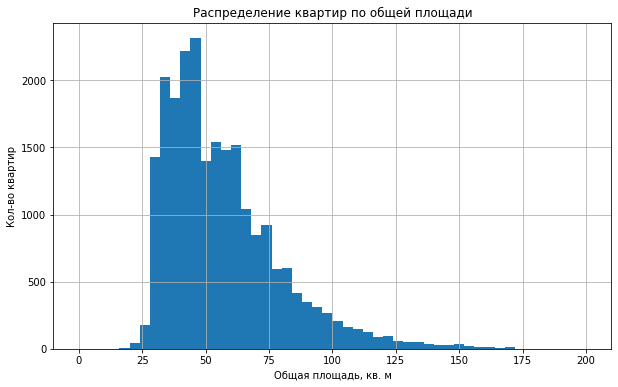

In [148]:
data['total_area'].plot(kind='hist',
                        bins=50, 
                        range=(0, 200), 
                        figsize=(10, 6), 
                        title='Распределение квартир по общей площади',
                        grid=True
                       )
                        
plt.xlabel('Общая площадь, кв. м');
plt.ylabel('Кол-во квартир');

Плотностная диаграмма распределения:

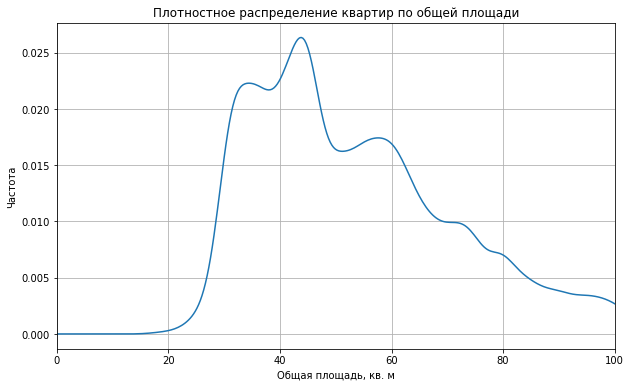

In [149]:
data['total_area'].plot.density(bw_method=0.09, grid=True, figsize=(10, 6))
plt.xlim(0, 100);
plt.title('Плотностное распределение квартир по общей площади');
plt.xlabel('Общая площадь, кв. м');
plt.ylabel('Частота');

In [150]:
data['total_area'].describe()

count    22555.000000
mean        56.319613
std         22.619414
min         18.000000
25%         40.000000
50%         51.000000
75%         67.000000
max        171.000000
Name: total_area, dtype: float64

In [151]:
print('Топ населенных пунктов по квартирам общей площадью 43 кв. м:', 
      ', '.join(data.query('40 < total_area < 45')['locality_name'].value_counts().head(3).index.values))

Топ населенных пунктов по квартирам общей площадью 43 кв. м: Санкт-Петербург, Шушары, Гатчина


In [152]:
print('Топ населенных пунктов по квартирам общей площадью 33 кв. м:', 
      ', '.join(data.query('30 < total_area < 35')['locality_name'].value_counts().head(3).index.values))

Топ населенных пунктов по квартирам общей площадью 33 кв. м: Санкт-Петербург, Мурино, Кудрово


In [153]:
print('Топ населенных пунктов по квартирам общей площадью 57 кв. м:', 
      ', '.join(data.query('55 < total_area < 59')['locality_name'].value_counts().head(3).index.values))

Топ населенных пунктов по квартирам общей площадью 57 кв. м: Санкт-Петербург, Колпино, Всеволожск


In [154]:
print('Площадь самой маленькой квартиры:', data.total_area.min())
print('Площадь самой большой квартиры:', data.total_area.max())
data.query('total_area == 171')

Площадь самой маленькой квартиры: 18.0
Площадь самой большой квартиры: 171.0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_per_sq_m,weekday_exposition,month_exposition,year_exposition,floor_type,city_centers_nearest_km,airports_nearest_km,parks_nearest_rounded
10772,16,17850000.0,171.0,2017-07-31,3,2.55,11,80.0,10,False,...,230.0,NaN,104386.0,0,7,2017,другой,8.0,32.0,200.0
15474,14,20800000.0,171.0,2018-03-27,3,3.50,5,80.0,5,False,...,NaN,203.0,121637.0,1,3,2018,последний,6.0,25.0,400.0
21132,18,23000000.0,171.0,2018-10-09,4,2.85,12,86.0,8,False,...,155.0,NaN,134503.0,1,10,2018,другой,8.0,39.0,500.0


**Выводы:**
- Основная масса квартир по общей площади находится в диапазоне от 40 до 67 кв. м.  
- Чаще всего встречаются квартиры с общей площадью: 43, 33 и 57 кв. м.  
- В объявлениях именно в Питере можно встретить больше всего квартир площадью 43, 33 и 57 кв. м.  
- Самая маленькая квартира - 18 кв. м. Самая большая - 171 кв. м.

### living_area

Построим гистограмму по данным.

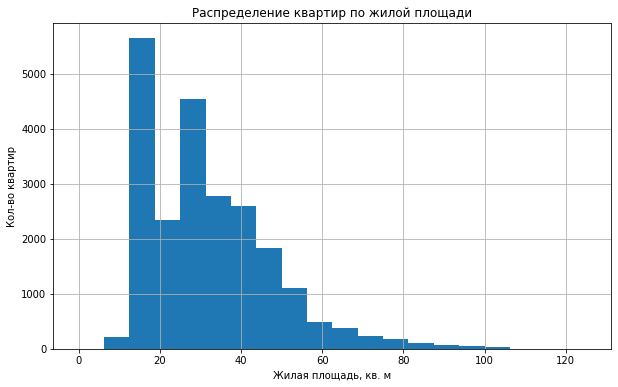

In [155]:
data['living_area'].plot(kind='hist',
                        bins=20, 
                        range=(0, 125), 
                        figsize=(10, 6), 
                        title='Распределение квартир по жилой площади',
                        grid=True
                       )
                        
plt.xlabel('Жилая площадь, кв. м');
plt.ylabel('Кол-во квартир');

Плотностная диаграмма распределения:

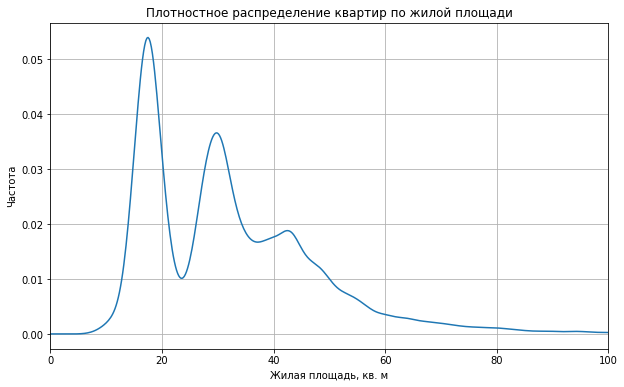

In [156]:
data['living_area'].plot.density(bw_method=0.1, grid=True, figsize=(10, 6))
plt.xlim(0, 100);
plt.title('Плотностное распределение квартир по жилой площади');
plt.xlabel('Жилая площадь, кв. м');
plt.ylabel('Частота');

In [157]:
data['living_area'].describe()

count    22555.000000
mean        32.148404
std         15.294153
min          8.000000
25%         18.500000
50%         30.000000
75%         41.000000
max        106.420000
Name: living_area, dtype: float64

In [158]:
data.groupby('rooms')['living_area'].median()

rooms
0    18.00
1    17.60
2    30.50
3    44.50
4    60.33
5    79.35
6    87.60
Name: living_area, dtype: float64

**Выводы:**
- Основная масса квартир по жилой площади находится в диапазоне от 18 до 41 кв. м.  
- Чаще всего встречаются квартиры с жилой площадью: 18, 30 и 43 кв. м. Это соответственно однушки, двушки и трехкомнатные квартиры.
- В объявлениях встречается "просадка" квартир с жилой площадью 22-24 кв. м.
- Самая маленькая квартира по жилой площади - 8 кв. м. Самая большая - 106 кв. м.

### kitchen_area

Построим гистограмму по данным.

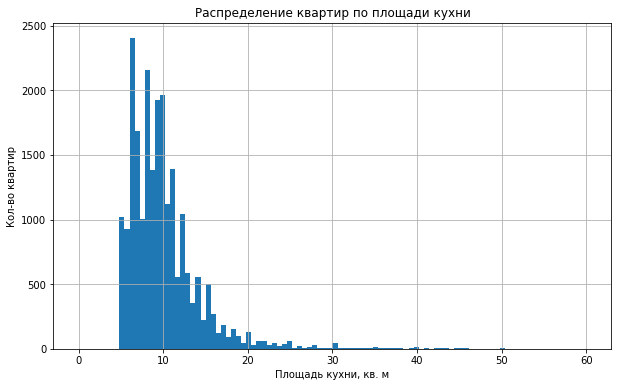

In [159]:
data['kitchen_area'].plot(kind='hist',
                        bins=100, 
                        range=(0, 60), 
                        figsize=(10, 6), 
                        title='Распределение квартир по площади кухни',
                        grid=True
                       )
                        
plt.xlabel('Площадь кухни, кв. м');
plt.ylabel('Кол-во квартир');

Плотностная диаграмма распределения:

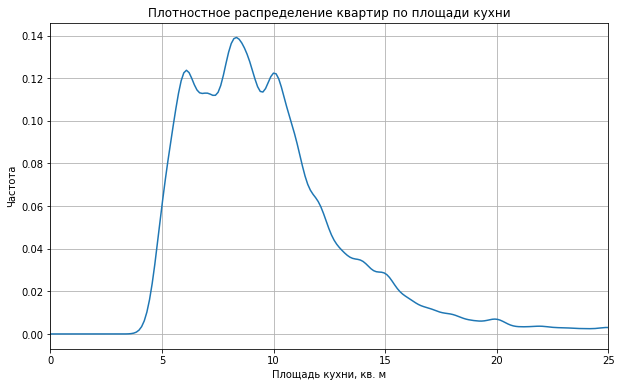

In [160]:
data['kitchen_area'].plot.density(bw_method=0.094, grid=True, figsize=(10, 6))
plt.xlim(0, 25);
plt.title('Плотностное распределение квартир по площади кухни');
plt.xlabel('Площадь кухни, кв. м');
plt.ylabel('Частота');

In [161]:
data['kitchen_area'].describe()

count    22555.000000
mean         9.992757
std          4.563450
min          5.000000
25%          7.000000
50%          9.000000
75%         11.300000
max         64.000000
Name: kitchen_area, dtype: float64

**Выводы:**
- Основная масса квартир имеет площадь кухни от 7 до 11 кв. м.  
- Чаще всего встречаются квартиры с кухнями: 8, 6 и 10 кв. м.  
- Самая маленькая кухня - 5 кв. м. Самая большая - 64 кв. м.

### last_price

Построим гистограмму по данным.

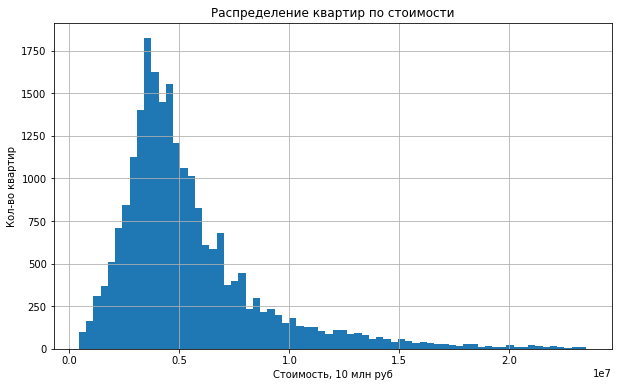

In [162]:
data['last_price'].plot(kind='hist',
                        bins=70, 
                        figsize=(10, 6), 
                        title='Распределение квартир по стоимости',
                        grid=True
                       )
                        
plt.xlabel('Стоимость, 10 млн руб');
plt.ylabel('Кол-во квартир');

Плотностная диаграмма распределения:

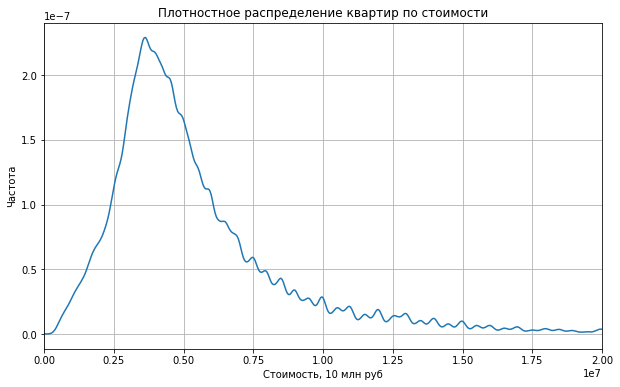

In [163]:
data['last_price'].plot.density(bw_method=0.037, grid=True, figsize=(10, 6))
plt.xlim(0, 20000000);
plt.title('Плотностное распределение квартир по стоимости');
plt.xlabel('Стоимость, 10 млн руб');
plt.ylabel('Частота');

In [164]:
data['last_price'].describe()

count    2.255500e+04
mean     5.444444e+06
std      3.323182e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.550000e+06
75%      6.500000e+06
max      2.350000e+07
Name: last_price, dtype: float64

In [165]:
data.groupby('rooms')['last_price'].median().head(4)

rooms
0    2700000.0
1    3600000.0
2    4750000.0
3    6025000.0
Name: last_price, dtype: float64

**Выводы:**
- Основная масса квартир имеет ценник от 3.4 до 6.5 млн руб. 
- Чаще всего встречаются квартиры с стоимостью 3.5 кв. м.  
- Самая дешевая квартира - 430 тыс руб. Самая дорогая - 23.5 млн руб.
- Медианные значения цен по кол-ву комнат:
    * Квартира-студия: 2.7 млн руб.
    * Однокомнатная: 3.6 млн руб.
    * Двукомнатная: 4.75 млн руб.
    * Трехкомнатная: 6 млн руб.

### rooms

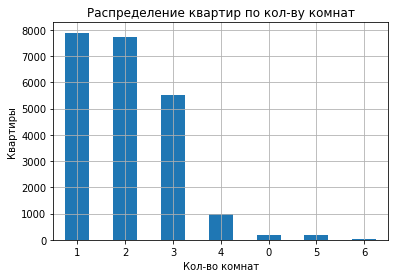

In [166]:
data['rooms'].value_counts().plot(kind='bar',
                                  grid=True,
                                  title='Распределение квартир по кол-ву комнат',
                                  xlabel='Кол-во комнат',
                                  ylabel='Квартиры');
plt.xticks(rotation=0);

**Выводы**:
- Преобладающее кол-во объявлений - объявления с однушками, двушками и трешками.
- По кол-во объявлений лидируют однушки, затем двушки, а потом трешки. Причем однушки и двушки представлены примерно одинаковым кол-вом объявлений.

### ceiling_height

Плотностная диаграмма распределения:

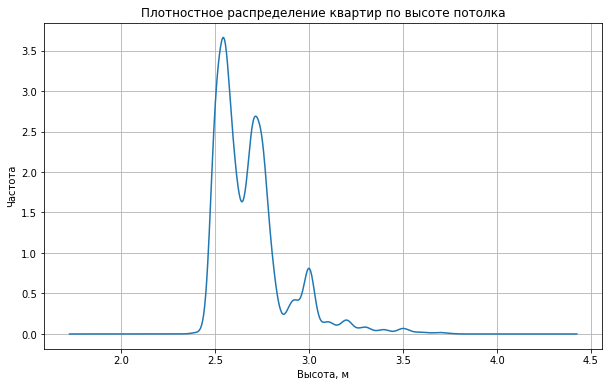

In [167]:
data['ceiling_height'].plot.density(bw_method=0.15, grid=True, figsize=(10, 6))
plt.title('Плотностное распределение квартир по высоте потолка');
plt.xlabel('Высота, м');
plt.ylabel('Частота');

In [168]:
data['ceiling_height'].describe()

count    22555.000000
mean         2.687621
std          0.191543
min          2.400000
25%          2.550000
50%          2.650000
75%          2.750000
max          3.750000
Name: ceiling_height, dtype: float64

**Выводы:**
- Высота потолков у большей части квартир варьируется от 2.55 до 2.75 м.
- Чаще всего встречаются квартиры с высотой потолка: 2.55, 2.7 и 3 м.
- Самые низкие потолки - 2.4 м. Самые высокие - 3.75 м.

### floor

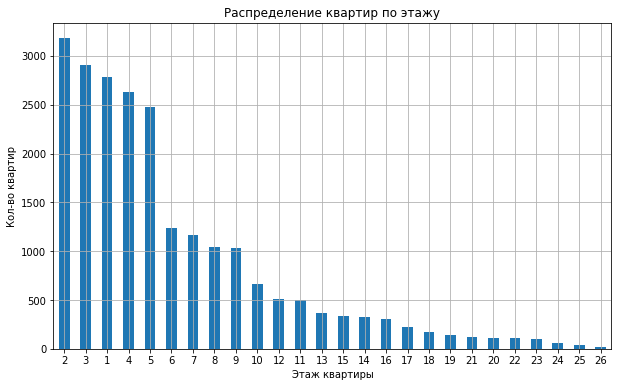

In [169]:
data.floor.value_counts().head(50).plot(kind='bar',
                                        grid=True,
                                        title='Распределение квартир по этажу',
                                        xlabel='Этаж квартиры',
                                        ylabel='Кол-во квартир',
                                        figsize=(10, 6)
                                       );
plt.xticks(rotation=0);

**Выводы:**
- Чаще всего квартира находится на втором этаже. 
- Чаще всего квартиры располагаются не выше 5 этажа.
- Реже всего квартира находится на 26 этаже.

### floor_type

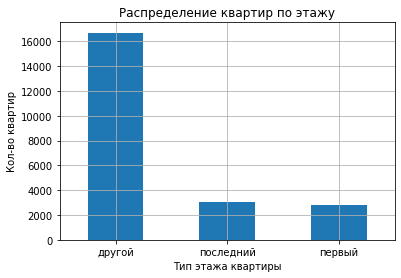

In [170]:
data['floor_type'].value_counts().plot(kind='bar',
                                       grid=True,
                                       title='Распределение квартир по этажу',
                                       xlabel='Тип этажа квартиры',
                                       ylabel='Кол-во квартир'
                                      );
plt.xticks(rotation=0);

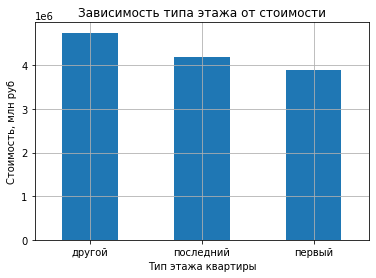

In [171]:
data.groupby('floor_type')['last_price'].median().sort_values(ascending=False)\
                                      .plot(kind='bar',
                                       grid=True,
                                       title='Зависимость типа этажа от стоимости',
                                       xlabel='Тип этажа квартиры',
                                       ylabel='Стоимость, млн руб'
                                      );
plt.xticks(rotation=0);

In [172]:
print('Доля квартир с балконами в зависимости от типа этажа:')

print('- Первом этаже:', round(data.query('balcony > 0 & floor_type == "первый"').shape[0]\
                               / data.query('floor_type == "первый"').shape[0], 2))

print('- Последнем этаже:', round(data.query('balcony > 0 & floor_type == "последний"').shape[0]\
                                  / data.query('floor_type == "последний"').shape[0], 2))

print('- Другом этаже:', round(data.query('balcony > 0 & floor_type == "другой"').shape[0]\
                               / data.query('floor_type == "другой"').shape[0], 2))

Доля квартир с балконами в зависимости от типа этажа:
- Первом этаже: 0.14
- Последнем этаже: 0.36
- Другом этаже: 0.4


**Выводы:**
- Меньшая часть представленных квартир расположена на последнем или первом этаже.
- Квартиры на первом этаже стоят дешевле.
- На первом этаже балконы встречаются реже, чем у квартир на последнем или другом этаже.

### floors_total

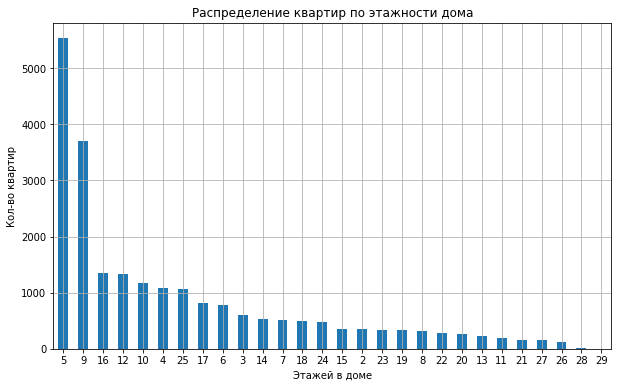

In [173]:
data['floors_total'].value_counts().plot(kind='bar',
                                       grid=True,
                                       title='Распределение квартир по этажности дома',
                                       xlabel='Этажей в доме',
                                       ylabel='Кол-во квартир',
                                       figsize=(10, 6)
                                      );
plt.xticks(rotation=0);

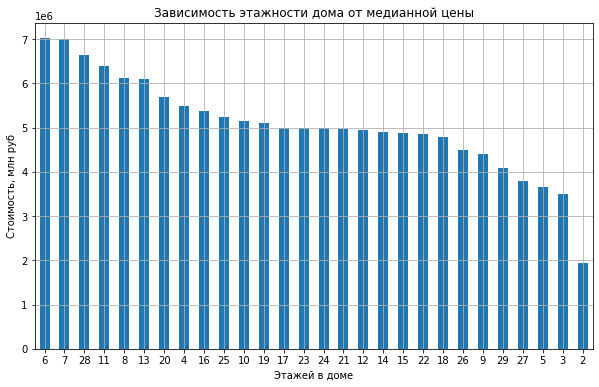

In [174]:
data.groupby('floors_total')['last_price'].median().sort_values(ascending=False)\
                                 .plot(kind='bar',
                                       grid=True,
                                       title='Зависимость этажности дома от медианной цены',
                                       xlabel='Этажей в доме',
                                       ylabel='Стоимость, млн руб',
                                       figsize=(10, 6)
                                      );
plt.xticks(rotation=0);

**Выводы:**
- Большая часть квартир находится в пятиэтажках и девятиэтажках. Пятиэтажные здания лидируют.
- В 6- и 7-этажных домах квартиры стоят в среднем больше, чем в других. Квартира в двухэтажном доме обычно самая дешевая.

### city_centers_nearest

count    17803.000000
mean     14585.761978
std       8081.214207
min        208.000000
25%      10096.000000
50%      13460.000000
75%      16802.000000
max      53294.000000
Name: city_centers_nearest, dtype: float64

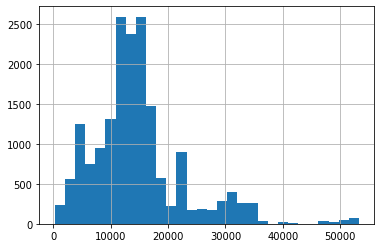

In [175]:
data['city_centers_nearest'].hist(bins=30);
data['city_centers_nearest'].describe()

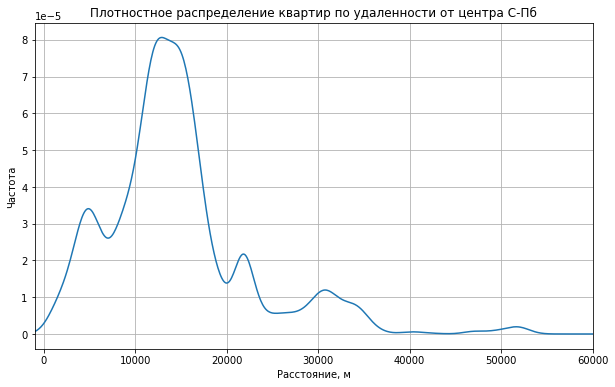

In [176]:
data['city_centers_nearest'].plot.density(bw_method=0.13, grid=True, figsize=(10, 6));
plt.xlim(-1000, 60000)
plt.title('Плотностное распределение квартир по удаленности от центра С-Пб');
plt.xlabel('Расстояние, м');
plt.ylabel('Частота');

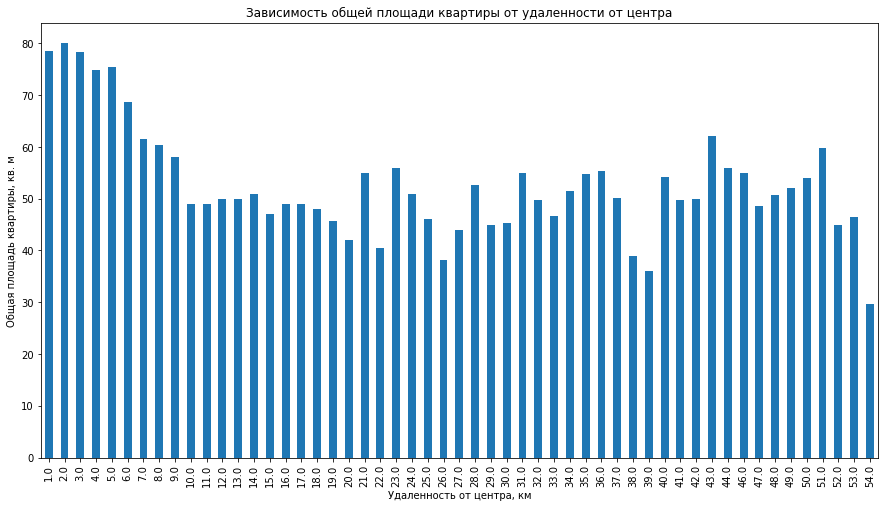

In [177]:
data.groupby('city_centers_nearest_km')['total_area'].median().plot(kind='bar', figsize=(15, 8));
plt.title('Зависимость общей площади квартиры от удаленности от центра');
plt.xlabel('Удаленность от центра, км');
plt.ylabel('Общая площадь квартиры, кв. м');

**Выводы:**
- Большое скопление квартир расположено в: 5, 13, 21, 31 км от центра Санкт-Петербурга.
- Чаще всего квартиры в объявлениях расположены в 13 км.
- Основная масса квартир расположена в 10-16.8 км от центра.
- В пределах 5 км от центра расположены квартиры с наибольшей общей площадью.

### airports_nearest

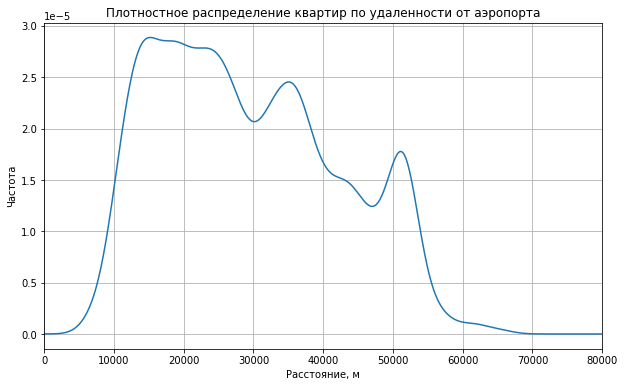

In [178]:
data['airports_nearest'].plot.density(bw_method=0.15, grid=True, figsize=(10, 6));
plt.xlim(0, 80000)
plt.title('Плотностное распределение квартир по удаленности от аэропорта');
plt.xlabel('Расстояние, м');
plt.ylabel('Частота');

**Вывод:**  

Большое скопление квартир расположено в: 20, 35, 51 км от аэропорта.

### parks_nearest 

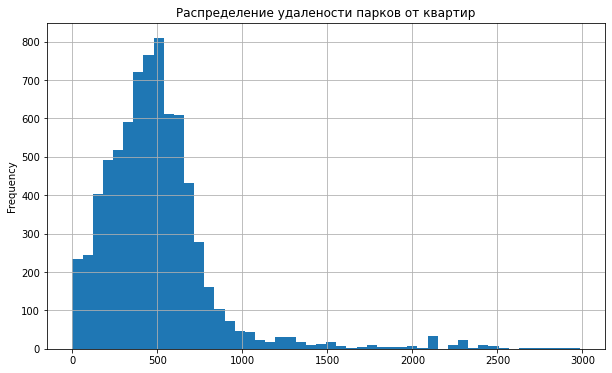

In [179]:
data.parks_nearest.plot(kind='hist',
                        bins=50,
                        title='Распределение удалености парков от квартир',
                        xlabel='Расстояние, м',
                        ylabel='Кол-во квартир',
                        figsize=(10, 6),
                        grid=True
                       );

In [180]:
data['parks_nearest'].describe()

count    7445.000000
mean      496.031430
std       339.565172
min         1.000000
25%       294.000000
50%       459.000000
75%       617.000000
max      2984.000000
Name: parks_nearest, dtype: float64

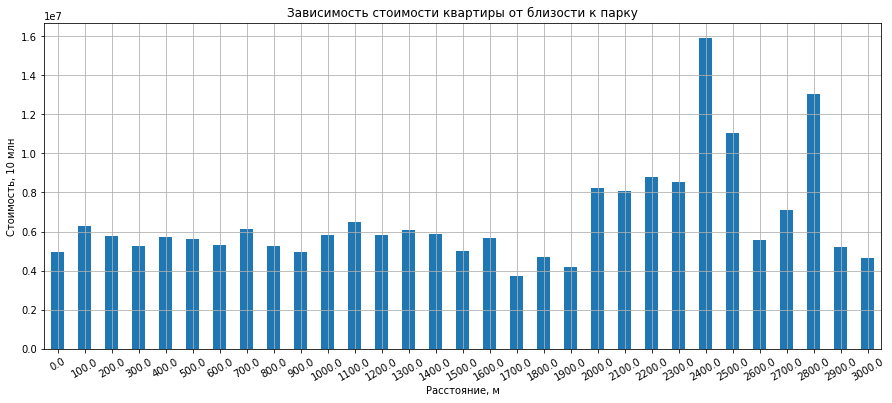

In [181]:
data.groupby('parks_nearest_rounded')['last_price'].median()\
                  .plot(kind='bar',
                        title='Зависимость стоимости квартиры от близости к парку',
                        xlabel='Расстояние, м',
                        ylabel='Стоимость, 10 млн',
                        figsize=(15, 6),
                        grid=True
                       );
plt.xticks(rotation=30);

Есть пики цен в 2400 и 2800 м, скорее всего это обусловлено сторонними факторами.

**Выводы:**
- Большинство парков находится в 500 м от квартиры.
- Обычно парки располагаются в 300-600 м от квартиры.
- Близость к парку никак не влияет на стоимость квартиры.

### weekday_exposition

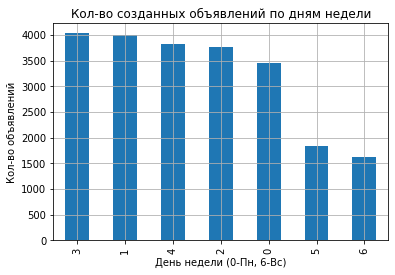

In [182]:
data['weekday_exposition'].value_counts().plot(kind='bar', 
                                               grid=True,
                                               title='Кол-во созданных объявлений по дням недели',
                                               xlabel='День недели (0-Пн, 6-Вс)',
                                               ylabel='Кол-во объявлений'
                                              );

**Вывод:**
- Меньше всего объявлений было опубликовано в субботу и воскресенье.

### month_exposition

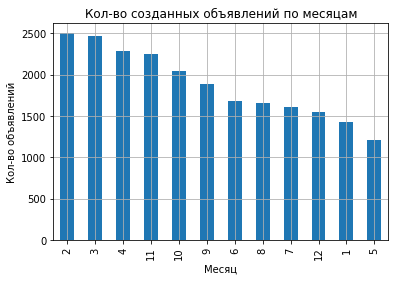

In [183]:
data['month_exposition'].value_counts().plot(kind='bar', 
                                             grid=True,
                                             title='Кол-во созданных объявлений по месяцам',
                                             xlabel='Месяц',
                                             ylabel='Кол-во объявлений'
                                            );

**Выводы:**  

- Февраль и март наиболее популярные месяцы для дачи объявления. В мае желающих продавать квартиру самое маленькое.

### Как быстро продавались квартиры?

count    19628.000000
mean       177.656868
std        216.078684
min          1.000000
25%         44.000000
50%         93.000000
75%        226.000000
max       1553.000000
Name: days_exposition, dtype: float64

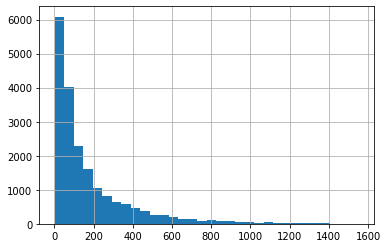

In [184]:
data['days_exposition'].hist(bins=32);
data['days_exposition'].describe()

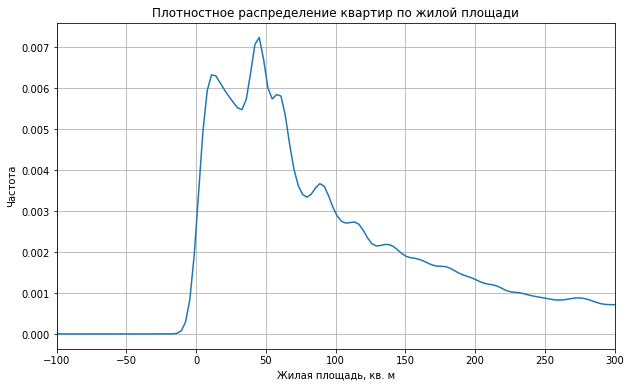

In [185]:
data['days_exposition'].plot.density(bw_method=0.0259, grid=True, figsize=(10, 6))
plt.xlim(-100, 300);
plt.title('Плотностное распределение квартир по жилой площади');
plt.xlabel('Жилая площадь, кв. м');
plt.ylabel('Частота');

**Выводы:**  

- По большей части объявлений кто-то откликается и покупает квартиру за 44-226 дней. 
- Медиана - 93 дня. Если объявление провисело меньше 93 дней, можно считать, что квартиру купили быстро.

### Факторы, больше всего влияющие на стоимость квартиры

Исследуем, как зависит стоимость квартиры от:
- общей площади;
- жилой площади;
- площади кухни;
- кол-ва комнат;
- типа этажа(первый, последний, другой);
- даты размещения.

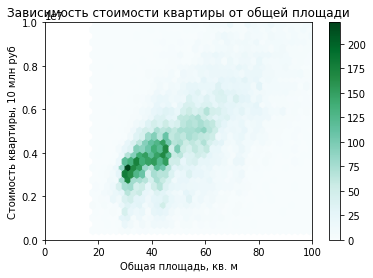

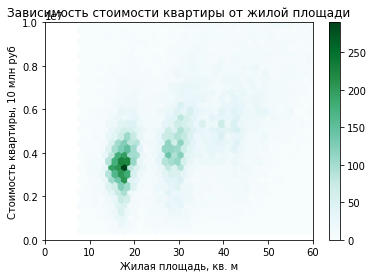

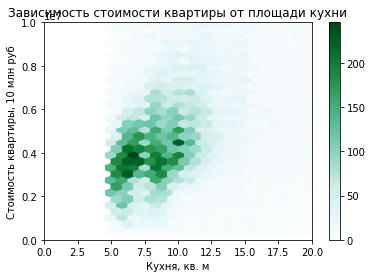

In [186]:
data.plot.hexbin(x='total_area',
                 y='last_price', 
                 gridsize=70, 
                 sharex=False,
                 title='Зависимость стоимости квартиры от общей площади',
                 xlabel='Общая площадь, кв. м',
                 ylabel='Стоимость квартиры, 10 млн руб'
                 );

plt.xlim(0, 100);
plt.ylim(0, 10000000);

data.plot.hexbin(x='living_area',
                 y='last_price', 
                 gridsize=70, 
                 sharex=False,
                 title='Зависимость стоимости квартиры от жилой площади',
                 xlabel='Жилая площадь, кв. м',
                 ylabel='Стоимость квартиры, 10 млн руб'
                 );

plt.xlim(0, 60);
plt.ylim(0, 10000000);

data.plot.hexbin(x='kitchen_area',
                 y='last_price', 
                 gridsize=70, 
                 sharex=False,
                 title='Зависимость стоимости квартиры от площади кухни',
                 xlabel='Кухня, кв. м',
                 ylabel='Стоимость квартиры, 10 млн руб'
                 );

plt.xlim(0, 20);
plt.ylim(0, 10000000);

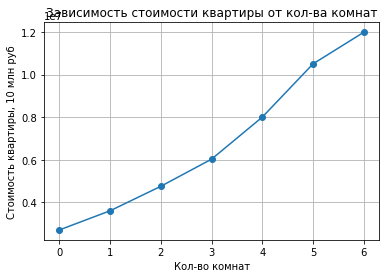

In [187]:
data.pivot_table(index='rooms', values='last_price', aggfunc='median')\
    .plot(grid=True,
          style='o-',
          title='Зависимость стоимости квартиры от кол-ва комнат',
          xlabel='Кол-во комнат',
          ylabel='Стоимость квартиры, 10 млн руб',
          legend=False
         );

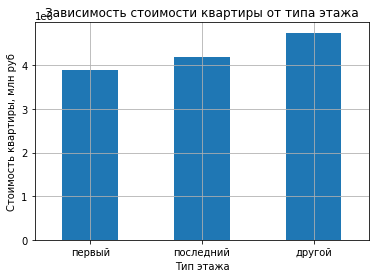

In [188]:
data.pivot_table(index='floor_type', values='last_price', aggfunc='median')\
    .sort_values('last_price')\
        .plot(kind='bar', 
              grid=True,
              legend=False,
              title='Зависимость стоимости квартиры от типа этажа',
              xlabel='Тип этажа',
              ylabel='Стоимость квартиры, млн руб'
             );
plt.xticks(rotation=0);

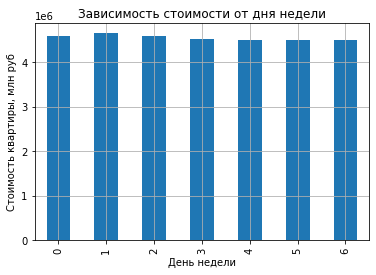

In [189]:
data.pivot_table(index='weekday_exposition', values='last_price', aggfunc='median')\
        .plot(kind='bar',
              grid=True,
              title='Зависимость стоимости от дня недели',
              xlabel='День недели',
              ylabel='Стоимость квартиры, млн руб',
              legend=False);

**Выводы:**

- На графиках видна прямая зависимость цены от общей, жилой и кухонной площади. Для жилой и кухонной площади это очевидно, т.к. они входят в общую.
- Стоимость также зависит от кол-ва комнат. С ростом кол-ва комнат немного возрастает и скорость роста цены. Скорость замедляется при кол-ве комнат = 5.
- Квартиры дороже, если они расположены не на первом и не на последнем этаже. На первом - самые дешевые.
- Стоимость квартиры не зависит от дня, когда объявление выставлено.

### Cредняя цена кв. м в 10 населённых пунктах с наибольшим числом объявлений

,price_per_sq_m
locality_name,
Санкт-Петербург,103527.0
Пушкин,99725.5
Кудрово,93911.0
Парголово,91580.0
Мурино,83929.0
Шушары,76562.0
Колпино,74723.5
Гатчина,67696.0
Всеволожск,65539.0


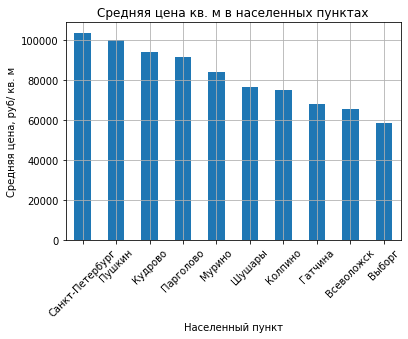

In [190]:
# получаем названия населенных пунктов с самым большим числом объявлений
top_localitites = data['locality_name'].value_counts().head(10).index

# делаем срез данных по определенным населенным пунктам и вычисляем медианную цену за кв. м, сортируем по убыванию
pvt_sq_meter_top = data.query('locality_name in @top_localitites')\
        .pivot_table(index='locality_name', values='price_per_sq_m', aggfunc='median')\
            .sort_values('price_per_sq_m', ascending=False)

display(pvt_sq_meter_top)

pvt_sq_meter_top.plot(kind='bar',
                      grid=True,
                      title='Средняя цена кв. м в населенных пунктах',
                      xlabel='Населенный пункт',
                      ylabel='Средняя цена, руб/ кв. м',
                      legend=False
                     );
plt.xticks(rotation=45);

**Вывод:**

Самая высокая стоимость квадратного метра в Питере, самая низкая - в Выборге. Стоимости различаются почти в два раза!

### Как стоимость объектов зависит от расстояния до центра города

Возьмем выборку из объявлений по Питеру.

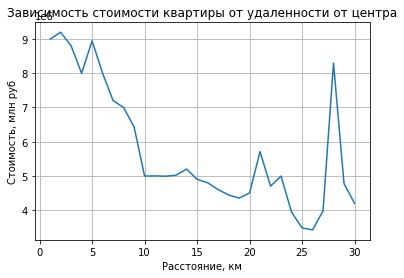

In [191]:
sp_price_per_km = data.query('locality_name == "Санкт-Петербург"')[['locality_name', 'city_centers_nearest_km', 'last_price']]
sp_price_per_km['discrete_km'] = round(sp_price_per_km['city_centers_nearest_km'], 0)
price_per_km = sp_price_per_km.pivot_table(index='discrete_km', values='last_price', aggfunc='median')

price_per_km.plot(grid=True,
                  legend=False,
                  title='Зависимость стоимости квартиры от удаленности от центра',
                  xlabel='Расстояние, км',
                  ylabel='Стоимость, млн руб'
                 );

**Вывод:**

- В общем случае, чем ближе квартира к центру, тем она дороже. На графике можно увидеть скачки в стоимости (5, 21, 27 км): это можно объяснить элитными квартирами и квартирами на берегу Финского залива.  
- На отрезке 10-15 км цена практически не меняется.

## Вывод

Была произведена предобработка данных: переименованы столбцы, заполнены пропуски, изменены типы данных, устранены аномальные значения, удалены дубликаты. Посчитаны и добавлены новые столбцы.  

Изучили факторы влияющие на цену. На стоимость квартиры влияет ее площадь, количество комнат, этаж и близость к центру.  

Дополнительно было выяснено:
- самый дорогой квадратный метр - в Питере;
- в среднем квартиру можно продать за 93 дня;
- зимой объявлений о продаже квартир больше, чем летом;
- в выходные объявлений выкладывают меньше, чем в будни.